# Problem 4

In [1]:
# from IPython.display import HTML
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <a href="javascript:code_toggle()">
# <button>Toggle Code</button></a>''')

In [2]:
# import libraries
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# set random seed
#np.random.seed(1000)

In [3]:
# import mnist data
mnist = sio.loadmat('mnist_all.mat')

# split training and test data
training_data = dict()
test_data = dict()
for key in mnist:
    if "train" in key:
        # store the data under digit key
        training_data[int(key[-1])] = mnist[key]
    if "test" in key:
        # store the data under digit key
        test_data[int(key[-1])] = mnist[key]
        
data = {0: np.array([[0.1,0.1],[0.2,0.2],[0.3,0.3],[0.4,0.4]]), 1: np.array([[6,6],[3,3],[4,4],[5,5]])}

In [4]:
class NeuralNetwork:
    """
        Create a class that defines a neural network
    """
    def __init__(self,data_input,lr=1,layers=(2,),iterations=100):
        """
            Initialize the network
        """
        # unpack input into data and labels
        self.data = np.zeros((0,data_input[0].shape[1]))
        self.labels = np.zeros((0,len(data_input)))
        for number in data_input:
            # concatenate data of each digit to array
            self.data = np.concatenate((self.data,data_input[number]),axis=0)
            
            # create labels
            lb = np.zeros((data_input[number].shape[0],len(data_input)))
            lb[:,number] = 1
            
            # concatenate labels to array
            self.labels = np.concatenate((self.labels,lb),axis=0)
        
        # scale data from [0,255] to [0,1]
        self.data = self.data/255
        
        # add bias term to data_input
        #bias = np.ones((self.data.shape[0],1))
        #self.data = np.concatenate((bias,self.data),axis=1)
        
        # Save learning rate and iterations
        self.lr = lr
        self.iterations = iterations
        
        # Create list to hold weights in each layer
        self.weights = list()
        
        # Initialize weights in each layer
        for n,layer in enumerate(layers):
            if n == 0:
                # set appropriate dimensions for input layer 
                self.weights.append(np.random.rand(self.data.shape[1],layer)) 
            else:
                # set appropriate dimensions for each hidden layer
                self.weights.append(np.random.rand(layers[n-1],layer))
        
        # Add final output layer to weights
        self.weights.append(np.random.rand(layers[-1],self.labels.shape[1]))
        
        # Display the network dimensions
        print("Input: {}".format(self.data.shape))
        for n,w in enumerate(self.weights):
            print("Layer{}: {}".format(n,w.shape))
        
        # Save MSE
        self.MSE = list()
        plt.figure()
        x = np.linspace(0,2,100)
        y = np.linspace(0,2,100)
        fill = np.array([x,y]).T
        points = self._logistic(np.dot(self._logistic(np.dot(fill,self.weights[0])),self.weights[1]))
        plt.scatter(points[:,0],points[:,1])
        plt.show()
        
    def _feedforward(self):
        """
            Do feedforward pass on network
        """
        # set initial output as data
        output = list()
        output.append(self.data)
        
        # loop over each layer and apply forward pass
        # save output from each layer
        for n,w in enumerate(self.weights):
            output.append(self._logistic(np.dot(output[n],w)))
        
        # return the output
        return output
    
    def _backpropagation(self,output,a=1):
        """
            Do backpropagation to calculate gradients
        """
        # calculate error between final output and labels
        error = self.labels - output[-1]
        print(error)
        
        # store MSE
        self.MSE.append(0.5*(np.linalg.norm(error.ravel(),ord=2)**2))
        
        # calculate gradients of each layer
        gradients = list()
        gradients.append(error*self._dlog(output[-1])) # add final layer gradient
        
        # calculate gradients of other layers
        for n in reversed(range(len(self.weights)-1)):
            # grab gradient from forward layer, dot with weights,
            # and multiply into current gradient
            gradients.append(self._dlog(output[n+1])*np.dot(gradients[-1],self.weights[n+1].T))
            
        # reverse gradient list
        gradients = gradients[::-1]
        
        # update new weights
        for i,grad in enumerate(gradients):
            self.weights[i] += self.lr*np.dot(output[i].T, grad)
            
        print(self.weights)
        x = np.linspace(0,2,100)
        y = np.linspace(0,2,100)
        fill = np.array([x,y]).T
        points = self._logistic(np.dot(self._logistic(np.dot(fill,self.weights[0])),self.weights[1]))
        plt.scatter(points[:,0],points[:,1])
        plt.show()
        
    @staticmethod
    def _logistic(data,a=1):
        """Logistic Function"""
        return 1/(1 + np.exp(-a*data))
    
    @staticmethod
    def _dlog(output,a=1):
        """Derivative of Logistic Function"""
        return a*output*(1-output)
    
    def train(self):
        """
            Train the neural network
        """
        # Loop over iterations
        for i in range(self.iterations):
            # do forward pass
            output = self._feedforward()

            # do backpropagation and update gradients
            self._backpropagation(output)
        
        # return output and classes
        return output[-1], np.argmax(output[-1],axis=1)

Input: (8, 2)
Layer0: (2, 2)
Layer1: (2, 2)


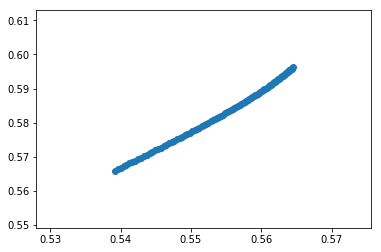

[[ 0.46084279 -0.56590393]
 [ 0.46083465 -0.56591235]
 [ 0.4608265  -0.56592077]
 [ 0.46081836 -0.56592919]
 [-0.53963766  0.43359956]
 [-0.53939339  0.43385199]
 [-0.53947483  0.43376784]
 [-0.53955625  0.43368369]]
[array([[0.91624902, 0.08883809],
       [0.76641151, 0.24849965]]), array([[0.12701812, 0.06496872],
       [0.10412342, 0.3388251 ]])]


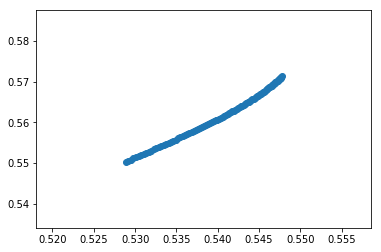

[[ 0.47113334 -0.55030889]
 [ 0.47112727 -0.55031432]
 [ 0.47112119 -0.55031974]
 [ 0.47111511 -0.55032517]
 [-0.52922526  0.44937105]
 [-0.52904294  0.44953378]
 [-0.52910372  0.44947953]
 [-0.52916449  0.44942529]]
[array([[0.916087  , 0.08922754],
       [0.76624949, 0.2488891 ]]), array([[0.09440497, 0.01810357],
       [0.07448508, 0.28949961]])]


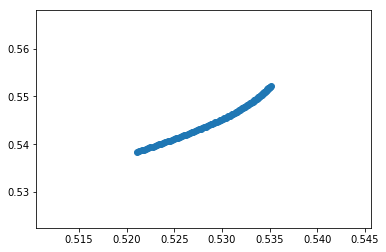

[[ 0.47889678 -0.53837791]
 [ 0.47889228 -0.53838104]
 [ 0.47888777 -0.53838416]
 [ 0.47888327 -0.53838729]
 [-0.5213688   0.46143761]
 [-0.52123377  0.46153141]
 [-0.52127878  0.46150014]
 [-0.52132379  0.46146887]]
[array([[0.91591564, 0.08961319],
       [0.76607813, 0.24927475]]), array([[ 0.06958085, -0.01694454],
       [ 0.0525891 ,  0.25190765]])]


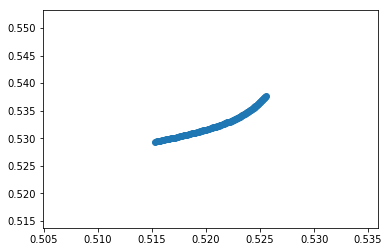

[[ 0.4847302  -0.52933804]
 [ 0.4847269  -0.52933943]
 [ 0.4847236  -0.52934082]
 [ 0.48472029 -0.52934221]
 [-0.51546461  0.47058   ]
 [-0.51536556  0.47062168]
 [-0.51539858  0.47060778]
 [-0.51543159  0.47059389]]
[array([[0.91573301, 0.08998858],
       [0.7658955 , 0.24965014]]), array([[ 0.05063357, -0.04295408],
       [ 0.0365333 ,  0.2232932 ]])]


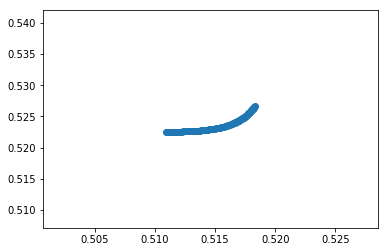

[[ 0.48910348 -0.52252722]
 [ 0.48910109 -0.52252731]
 [ 0.4890987  -0.52252739]
 [ 0.48909631 -0.52252748]
 [-0.51103751  0.47746756]
 [-0.51096583  0.47747022]
 [-0.51098973  0.47746934]
 [-0.51101362  0.47746845]]
[array([[0.91554023, 0.0903515 ],
       [0.76570272, 0.25001306]]), array([[ 0.03610268, -0.06211785],
       [ 0.02486526,  0.20148012]])]


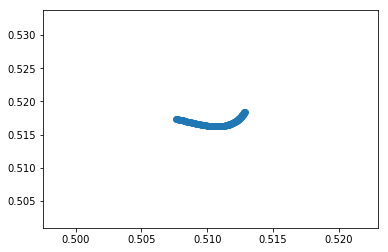

[[ 0.4923779  -0.51741236]
 [ 0.49237621 -0.51741148]
 [ 0.49237451 -0.51741061]
 [ 0.49237282 -0.51740973]
 [-0.50772207  0.48263941]
 [-0.50767124  0.48261309]
 [-0.50768819  0.48262187]
 [-0.50770513  0.48263064]]
[array([[0.91533956, 0.09070178],
       [0.76550205, 0.25036333]]), array([[ 0.02488325, -0.07612571],
       [ 0.01648639,  0.1847908 ]])]


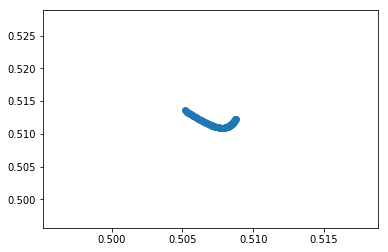

[[ 0.49482782 -0.51357821]
 [ 0.49482665 -0.51357662]
 [ 0.49482549 -0.51357503]
 [ 0.49482433 -0.51357344]
 [-0.50524078  0.48651559]
 [-0.5052059   0.48646791]
 [-0.50521753  0.48648381]
 [-0.50522916  0.4864997 ]]
[array([[0.91513348, 0.09104011],
       [0.76529597, 0.25070167]]), array([[ 0.01614376, -0.08626274],
       [ 0.01057006,  0.17194912]])]


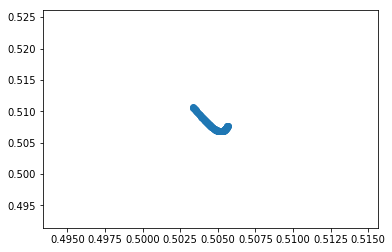

[[ 0.49666007 -0.51070705]
 [ 0.49665931 -0.51070494]
 [ 0.49665856 -0.51070282]
 [ 0.49665781 -0.51070071]
 [-0.50338438  0.48941751]
 [-0.50336178  0.48935419]
 [-0.50336931  0.4893753 ]
 [-0.50337685  0.48939641]]
[array([[0.91492428, 0.09136749],
       [0.76508677, 0.25102905]]), array([[ 0.00926025, -0.09349901],
       [ 0.00649606,  0.16199162]])]


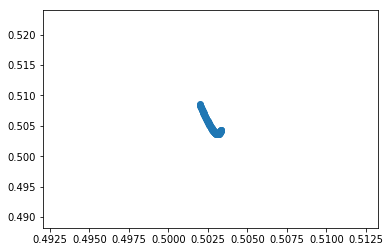

[[ 0.49803004 -0.50855825]
 [ 0.4980296  -0.50855576]
 [ 0.49802916 -0.50855327]
 [ 0.49802873 -0.50855078]
 [-0.50199567  0.49158862]
 [-0.5019826   0.49151395]
 [-0.50198696  0.49153884]
 [-0.50199132  0.49156373]]
[array([[0.9147139 , 0.09168491],
       [0.7648764 , 0.25134647]]), array([[ 0.00376526, -0.09856373],
       [ 0.00379981,  0.15419392]])]


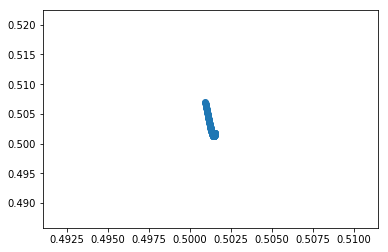

[[ 0.49905418 -0.50695056]
 [ 0.49905399 -0.5069478 ]
 [ 0.49905381 -0.50694504]
 [ 0.49905362 -0.50694228]
 [-0.50095685  0.49321228]
 [-0.50095124  0.49312949]
 [-0.50095311  0.49315709]
 [-0.50095498  0.49318469]]
[array([[0.91450393, 0.09199325],
       [0.76466642, 0.25165481]]), array([[-0.00069106, -0.10200379],
       [ 0.00213359,  0.14801268]])]


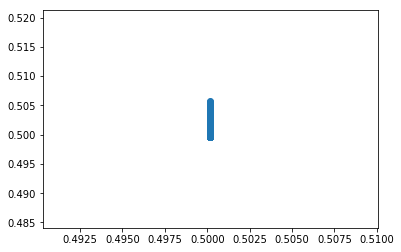

[[ 0.4998197  -0.50574791]
 [ 0.49981971 -0.50574496]
 [ 0.49981972 -0.505742  ]
 [ 0.49981973 -0.50573905]
 [-0.50017969  0.49442617]
 [-0.50018     0.49433767]
 [-0.5001799   0.49436717]
 [-0.50017979  0.49439668]]
[array([[0.91429562, 0.09229325],
       [0.76445811, 0.25195481]]), array([[-0.00437049, -0.10422882],
       [ 0.0012373 ,  0.14304091]])]


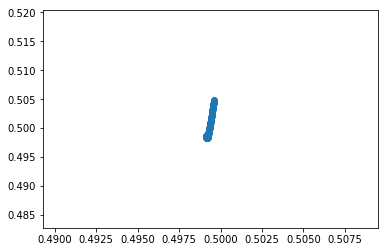

[[ 0.50039182 -0.50484828]
 [ 0.50039199 -0.5048452 ]
 [ 0.50039216 -0.50484212]
 [ 0.50039233 -0.50483903]
 [-0.49959819  0.49533349]
 [-0.49960327  0.49524108]
 [-0.49960158  0.49527189]
 [-0.49959988  0.49530269]]
[array([[0.91408993, 0.09258551],
       [0.76425242, 0.25224707]]), array([[-0.00746877, -0.10554537],
       [ 0.00091644,  0.13897398]])]


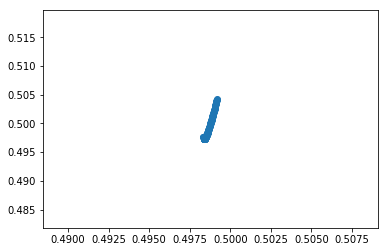

[[ 0.50081934 -0.50417531]
 [ 0.50081964 -0.50417215]
 [ 0.50081994 -0.50416898]
 [ 0.50082024 -0.50416581]
 [-0.49916299  0.4960115 ]
 [-0.49917197  0.49591652]
 [-0.49916898  0.49594819]
 [-0.49916599  0.49597985]]
[array([[0.91388763, 0.0928705 ],
       [0.76405012, 0.25253206]]), array([[-0.01013231, -0.10618279],
       [ 0.00102555,  0.13558396]])]


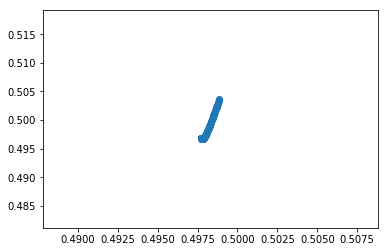

[[ 0.50113875 -0.50367186]
 [ 0.50113916 -0.50366864]
 [ 0.50113957 -0.50366542]
 [ 0.50113997 -0.5036622 ]
 [-0.49883718  0.49651802]
 [-0.49884942  0.49642148]
 [-0.49884534  0.49645367]
 [-0.49884126  0.49648584]]
[array([[0.91368928, 0.09314859],
       [0.76385177, 0.25281015]]), array([[-0.01247057, -0.10631262],
       [ 0.00145589,  0.13270036]])]


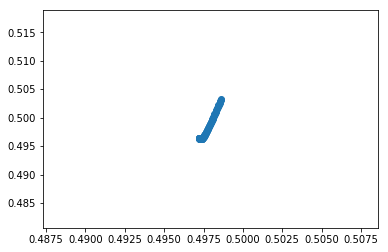

[[ 0.50137733 -0.50329517]
 [ 0.50137783 -0.50329193]
 [ 0.50137833 -0.50328868]
 [ 0.50137883 -0.50328544]
 [-0.49859315  0.4968963 ]
 [-0.49860816  0.49679895]
 [-0.49860315  0.4968314 ]
 [-0.49859815  0.49686385]]
[array([[0.91349532, 0.09342007],
       [0.76365781, 0.25308162]]), array([[-0.0145654 , -0.10606313],
       [ 0.00212617,  0.13019569]])]


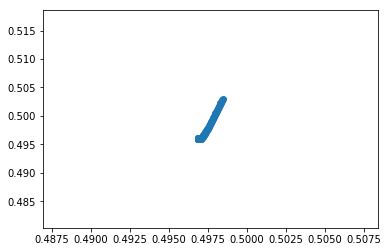

[[ 0.50155548 -0.50301328]
 [ 0.50155606 -0.50301002]
 [ 0.50155664 -0.50300677]
 [ 0.50155722 -0.50300352]
 [-0.49841027  0.49717868]
 [-0.49842768  0.49708109]
 [-0.49842188  0.49711362]
 [-0.49841607  0.49714615]]
[array([[0.91330607, 0.09368514],
       [0.76346856, 0.2533467 ]]), array([[-0.01647802, -0.10553024],
       [ 0.00297561,  0.12797457]])]


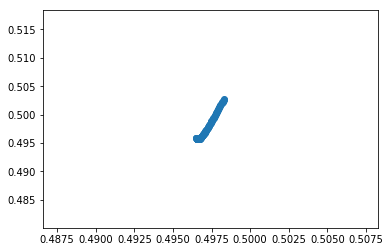

[[ 0.50168845 -0.50280226]
 [ 0.5016891  -0.50279901]
 [ 0.50168975 -0.50279577]
 [ 0.5016904  -0.50279252]
 [-0.4982731   0.49738936]
 [-0.49829265  0.49729194]
 [-0.49828613  0.49732442]
 [-0.49827961  0.49735689]]
[array([[0.91312177, 0.09394399],
       [0.76328426, 0.25360554]]), array([[-0.01825417, -0.10478567],
       [ 0.00395876,  0.12596569]])]


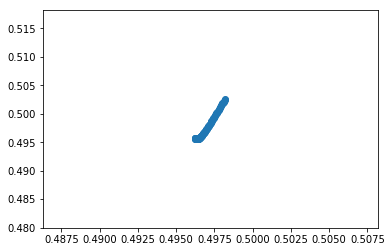

[[ 0.50178764 -0.50264425]
 [ 0.50178835 -0.50264101]
 [ 0.50178907 -0.50263778]
 [ 0.50178978 -0.50263455]
 [-0.49817011  0.49754643]
 [-0.49819159  0.49744949]
 [-0.49818443  0.49748181]
 [-0.49817727  0.49751412]]
[array([[0.91294262, 0.09419672],
       [0.76310511, 0.25385828]]), array([[-0.0199281 , -0.10388303],
       [ 0.00504167,  0.12411574]])]


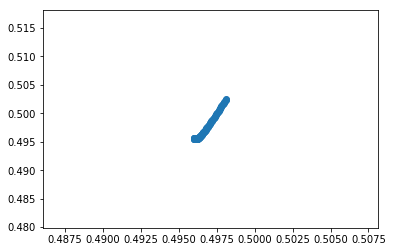

[[ 0.50186157 -0.50252586]
 [ 0.50186235 -0.50252265]
 [ 0.50186312 -0.50251944]
 [ 0.5018639  -0.50251623]
 [-0.49809267  0.49766342]
 [-0.49811594  0.49756719]
 [-0.49810818  0.49759927]
 [-0.49810043  0.49763134]]
[array([[0.91276874, 0.09444345],
       [0.76293123, 0.25410501]]), array([[-0.02152539, -0.1028624 ],
       [ 0.00619896,  0.12238483]])]


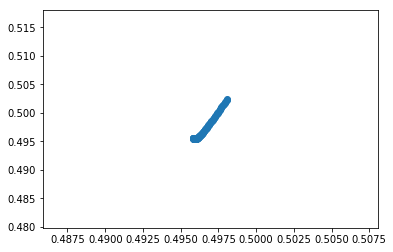

[[ 0.50191663 -0.5024371 ]
 [ 0.50191746 -0.50243393]
 [ 0.50191829 -0.50243075]
 [ 0.50191912 -0.50242757]
 [-0.49803435  0.49775043]
 [-0.49805927  0.49765508]
 [-0.49805096  0.49768687]
 [-0.49804265  0.49771865]]
[array([[0.91260024, 0.09468425],
       [0.76276273, 0.2543458 ]]), array([[-0.02306518, -0.10175377],
       [ 0.00741164,  0.12074313]])]


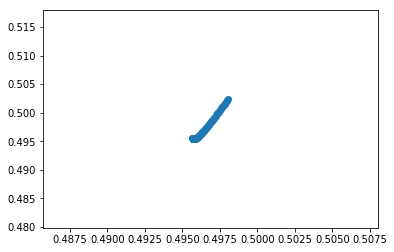

[[ 0.50195757 -0.50237051]
 [ 0.50195845 -0.50236736]
 [ 0.50195933 -0.50236422]
 [ 0.50196022 -0.50236107]
 [-0.4979903   0.49781503]
 [-0.49801681  0.4977207 ]
 [-0.49800797  0.49775215]
 [-0.49799914  0.49778359]]
[array([[0.9124372 , 0.09491916],
       [0.76259969, 0.25458072]]), array([[-0.02456178, -0.10057952],
       [ 0.00866554,  0.11916834]])]


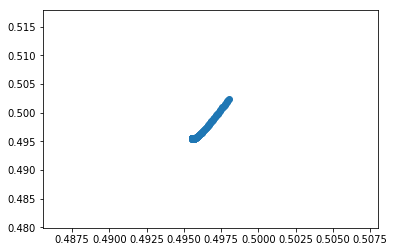

[[ 0.50198795 -0.50232048]
 [ 0.50198889 -0.50231737]
 [ 0.50198982 -0.50231426]
 [ 0.50199076 -0.50231115]
 [-0.49795694  0.49786289]
 [-0.49798496  0.49776966]
 [-0.49797562  0.49780074]
 [-0.49796628  0.49783182]]
[array([[0.91227966, 0.09514824],
       [0.76244215, 0.2548098 ]]), array([[-0.0260259 , -0.09935639],
       [ 0.00995006,  0.11764376]])]


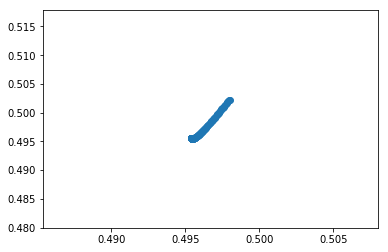

[[ 0.50201045 -0.50228284]
 [ 0.50201144 -0.50227977]
 [ 0.50201242 -0.5022767 ]
 [ 0.5020134  -0.50227363]
 [-0.49793156  0.49789821]
 [-0.49796104  0.49780617]
 [-0.49795122  0.49783685]
 [-0.49794139  0.49786753]]
[array([[0.91212768, 0.09537151],
       [0.76229017, 0.25503307]]), array([[-0.02746556, -0.09809691],
       [ 0.01125729,  0.11615693]])]


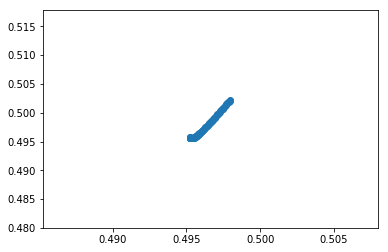

[[ 0.50202705 -0.50225446]
 [ 0.50202808 -0.50225143]
 [ 0.50202911 -0.5022484 ]
 [ 0.50203014 -0.50224537]
 [-0.49791216  0.49792418]
 [-0.49794306  0.49783336]
 [-0.49793276  0.49786363]
 [-0.49792246  0.49789391]]
[array([[0.91198128, 0.09558901],
       [0.76214377, 0.25525057]]), array([[-0.02888675, -0.09681042],
       [ 0.01258132,  0.11469849]])]


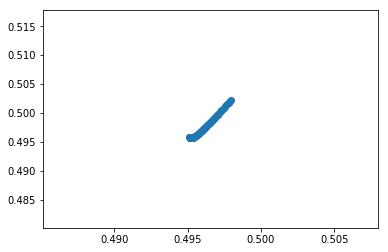

[[ 0.50203924 -0.50223301]
 [ 0.50204032 -0.50223002]
 [ 0.5020414  -0.50222704]
 [ 0.50204248 -0.50222405]
 [-0.49789722  0.49794314]
 [-0.49792952  0.49785358]
 [-0.49791875  0.49788344]
 [-0.49790798  0.49791329]]
[array([[0.91184048, 0.09580075],
       [0.76200297, 0.25546231]]), array([[-0.03029396, -0.09550391],
       [ 0.01391773,  0.11326146]])]


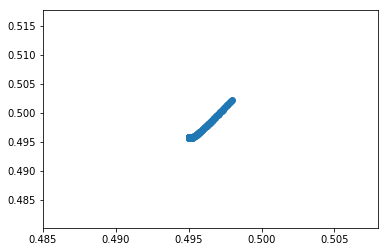

[[ 0.50204814 -0.50221674]
 [ 0.50204926 -0.50221379]
 [ 0.50205039 -0.50221085]
 [ 0.50205151 -0.50220791]
 [-0.49788561  0.49795687]
 [-0.49791929  0.4978686 ]
 [-0.49790807  0.49789803]
 [-0.49789684  0.49792745]]
[array([[0.91170529, 0.09600674],
       [0.76186779, 0.2556683 ]]), array([[-0.03169056, -0.09418259],
       [ 0.01526323,  0.11184062]])]


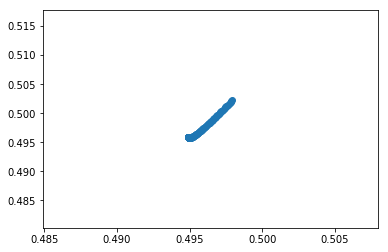

[[ 0.50205457 -0.50220434]
 [ 0.50205574 -0.50220144]
 [ 0.50205691 -0.50219854]
 [ 0.50205808 -0.50219564]
 [-0.49787651  0.49796668]
 [-0.49791155  0.49787973]
 [-0.49789987  0.49790872]
 [-0.49788818  0.4979377 ]]
[array([[0.91157574, 0.09620701],
       [0.76173823, 0.25586857]]), array([[-0.03307905, -0.09285035],
       [ 0.01661536,  0.11043203]])]


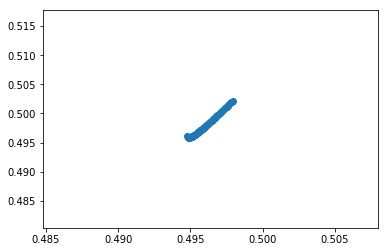

[[ 0.50205916 -0.50219484]
 [ 0.50206038 -0.50219199]
 [ 0.50206159 -0.50218913]
 [ 0.5020628  -0.50218628]
 [-0.49786927  0.49797358]
 [-0.49790565  0.49788795]
 [-0.49789352  0.4979165 ]
 [-0.49788139  0.49794504]]
[array([[0.91145182, 0.09640156],
       [0.76161431, 0.25606311]]), array([[-0.03446134, -0.09151011],
       [ 0.01797229,  0.10903278]])]


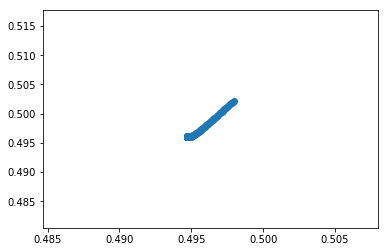

[[ 0.50206238 -0.50218751]
 [ 0.50206363 -0.5021847 ]
 [ 0.50206489 -0.50218189]
 [ 0.50206615 -0.50217908]
 [-0.49786342  0.49797829]
 [-0.49790115  0.49789399]
 [-0.49788857  0.49792209]
 [-0.49787599  0.49795019]]
[array([[0.91133354, 0.09659039],
       [0.76149603, 0.25625195]]), array([[-0.03583883, -0.09016403],
       [ 0.01933266,  0.10764065]])]


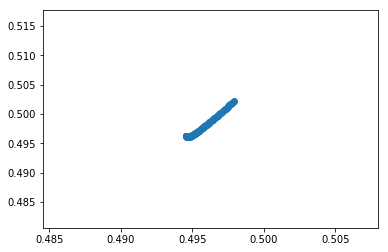

[[ 0.50206456 -0.5021818 ]
 [ 0.50206586 -0.50217903]
 [ 0.50206717 -0.50217626]
 [ 0.50206847 -0.5021735 ]
 [-0.49785862  0.49798136]
 [-0.49789768  0.49789841]
 [-0.49788466  0.49792606]
 [-0.49787164  0.49795371]]
[array([[0.91122091, 0.09677352],
       [0.7613834 , 0.25643508]]), array([[-0.0372126 , -0.08881373],
       [ 0.02069545,  0.10625399]])]


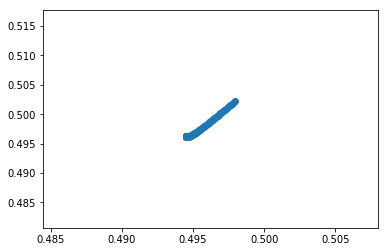

[[ 0.50206598 -0.5021773 ]
 [ 0.50206732 -0.50217458]
 [ 0.50206867 -0.50217186]
 [ 0.50207002 -0.50216913]
 [-0.4978546   0.49798322]
 [-0.49789498  0.49790161]
 [-0.49788152  0.49792881]
 [-0.49786806  0.49795602]]
[array([[0.91111392, 0.09695095],
       [0.76127641, 0.2566125 ]]), array([[-0.03858345, -0.08746041],
       [ 0.02205992,  0.10487157]])]


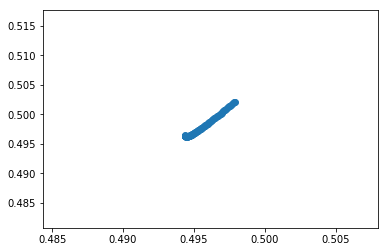

[[ 0.50206682 -0.50217371]
 [ 0.50206821 -0.50217103]
 [ 0.5020696  -0.50216835]
 [ 0.50207099 -0.50216568]
 [-0.49785116  0.49798416]
 [-0.49789286  0.4979039 ]
 [-0.49787896  0.49793066]
 [-0.49786506  0.49795741]]
[array([[0.91101258, 0.09712268],
       [0.76117507, 0.25678424]]), array([[-0.03995198, -0.08610495],
       [ 0.02342551,  0.10349245]])]


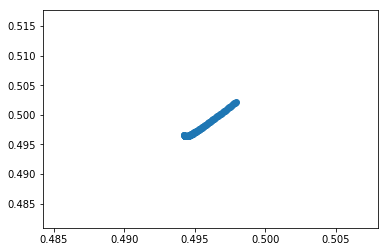

[[ 0.50206723 -0.50217079]
 [ 0.50206867 -0.50216816]
 [ 0.5020701  -0.50216553]
 [ 0.50207153 -0.5021629 ]
 [-0.49784816  0.49798442]
 [-0.49789118  0.49790551]
 [-0.49787684  0.49793182]
 [-0.4978625   0.49795812]]
[array([[0.91091688, 0.09728873],
       [0.76107937, 0.25695028]]), array([[-0.04131866, -0.08474802],
       [ 0.02479181,  0.10211593]])]


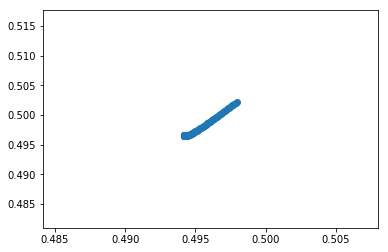

[[ 0.50206732 -0.50216839]
 [ 0.5020688  -0.5021658 ]
 [ 0.50207028 -0.50216322]
 [ 0.50207176 -0.50216063]
 [-0.49784549  0.49798418]
 [-0.49788982  0.49790661]
 [-0.49787504  0.49793247]
 [-0.49786026  0.49795833]]
[array([[0.91082683, 0.09744908],
       [0.76098932, 0.25711064]]), array([[-0.04268382, -0.08339011],
       [ 0.02615852,  0.10074147]])]


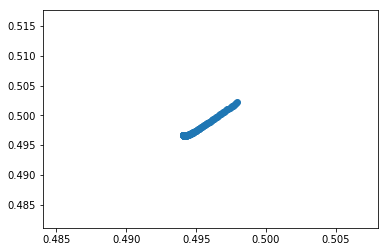

[[ 0.50206717 -0.50216636]
 [ 0.5020687  -0.50216382]
 [ 0.50207022 -0.50216128]
 [ 0.50207174 -0.50215874]
 [-0.49784306  0.49798356]
 [-0.4978887   0.49790734]
 [-0.49787349  0.49793275]
 [-0.49785827  0.49795815]]
[array([[0.91074242, 0.09760376],
       [0.76090491, 0.25726531]]), array([[-0.04404775, -0.08203158],
       [ 0.02752541,  0.09936867]])]


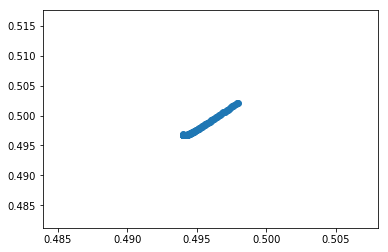

[[ 0.50206685 -0.50216463]
 [ 0.50206841 -0.50216213]
 [ 0.50206998 -0.50215963]
 [ 0.50207154 -0.50215714]
 [-0.49784082  0.49798265]
 [-0.49788776  0.49790777]
 [-0.49787211  0.49793274]
 [-0.49785646  0.4979577 ]]
[array([[0.91066365, 0.09775275],
       [0.76082615, 0.25741431]]), array([[-0.04541065, -0.08067269],
       [ 0.02889235,  0.09799722]])]


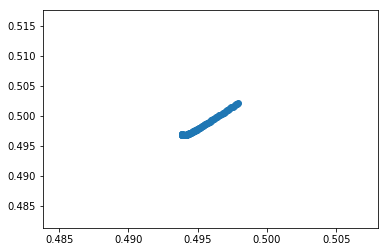

[[ 0.50206638 -0.5021631 ]
 [ 0.50206799 -0.50216065]
 [ 0.5020696  -0.5021582 ]
 [ 0.50207121 -0.50215574]
 [-0.49783871  0.49798154]
 [-0.49788696  0.497908  ]
 [-0.49787087  0.49793252]
 [-0.49785479  0.49795703]]
[array([[0.91059053, 0.09789606],
       [0.76075302, 0.25755762]]), array([[-0.04677266, -0.07931364],
       [ 0.0302592 ,  0.09662689]])]


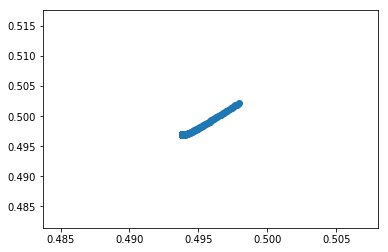

[[ 0.50206582 -0.50216174]
 [ 0.50206748 -0.50215933]
 [ 0.50206913 -0.50215692]
 [ 0.50207078 -0.50215451]
 [-0.4978367   0.49798026]
 [-0.49788626  0.49790807]
 [-0.49786974  0.49793214]
 [-0.49785322  0.4979562 ]]
[array([[0.91052305, 0.0980337 ],
       [0.76068554, 0.25769526]]), array([[-0.04813393, -0.07795455],
       [ 0.0316259 ,  0.09525749]])]


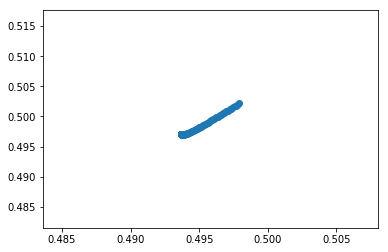

[[ 0.50206519 -0.50216049]
 [ 0.50206688 -0.50215813]
 [ 0.50206858 -0.50215577]
 [ 0.50207028 -0.5021534 ]
 [-0.49783477  0.49797887]
 [-0.49788563  0.49790802]
 [-0.49786868  0.49793164]
 [-0.49785172  0.49795526]]
[array([[0.91046121, 0.09816567],
       [0.7606237 , 0.25782723]]), array([[-0.04949455, -0.07659553],
       [ 0.03299239,  0.09388888]])]


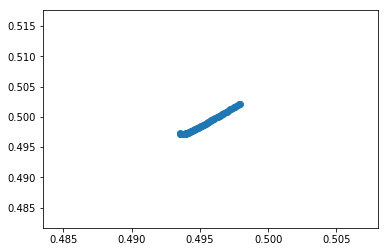

[[ 0.5020645  -0.50215934]
 [ 0.50206624 -0.50215702]
 [ 0.50206798 -0.5021547 ]
 [ 0.50206972 -0.50215238]
 [-0.4978329   0.4979774 ]
 [-0.49788507  0.49790788]
 [-0.49786767  0.49793106]
 [-0.49785029  0.49795423]]
[array([[0.910405  , 0.09829196],
       [0.7605675 , 0.25795352]]), array([[-0.05085459, -0.07523663],
       [ 0.03435864,  0.09252095]])]


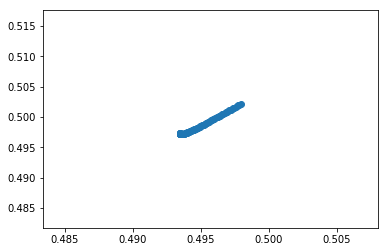

[[ 0.50206376 -0.50215825]
 [ 0.50206555 -0.50215598]
 [ 0.50206733 -0.50215371]
 [ 0.50206911 -0.50215143]
 [-0.49783107  0.49797586]
 [-0.49788454  0.49790767]
 [-0.49786671  0.4979304 ]
 [-0.49784889  0.49795313]]
[array([[0.91035444, 0.09841259],
       [0.76051693, 0.25807414]]), array([[-0.05221413, -0.07387792],
       [ 0.03572464,  0.0911536 ]])]


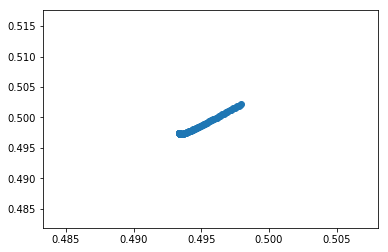

[[ 0.502063   -0.50215722]
 [ 0.50206483 -0.50215499]
 [ 0.50206665 -0.50215276]
 [ 0.50206848 -0.50215053]
 [-0.49782927  0.49797427]
 [-0.49788404  0.49790742]
 [-0.49786578  0.49792971]
 [-0.49784753  0.49795199]]
[array([[0.9103095 , 0.09852754],
       [0.76047199, 0.2581891 ]]), array([[-0.05357322, -0.0725194 ],
       [ 0.03709036,  0.08978677]])]


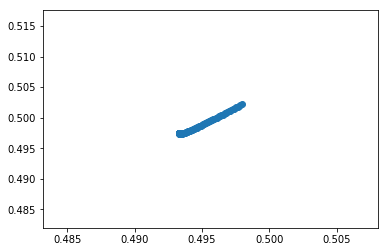

[[ 0.50206221 -0.50215622]
 [ 0.50206408 -0.50215404]
 [ 0.50206595 -0.50215185]
 [ 0.50206782 -0.50214967]
 [-0.4978275   0.49797265]
 [-0.49788357  0.49790713]
 [-0.49786488  0.49792897]
 [-0.49784619  0.49795081]]
[array([[0.9102702 , 0.09863683],
       [0.7604327 , 0.25829839]]), array([[-0.0549319 , -0.0711611 ],
       [ 0.03845582,  0.0884204 ]])]


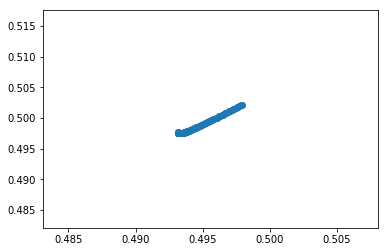

[[ 0.50206141 -0.50215526]
 [ 0.50206332 -0.50215312]
 [ 0.50206524 -0.50215098]
 [ 0.50206715 -0.50214884]
 [-0.49782574  0.497971  ]
 [-0.49788312  0.49790681]
 [-0.49786399  0.49792821]
 [-0.49784487  0.49794961]]
[array([[0.91023654, 0.09874046],
       [0.76039903, 0.25840202]]), array([[-0.05629022, -0.06980302],
       [ 0.03982102,  0.08705442]])]


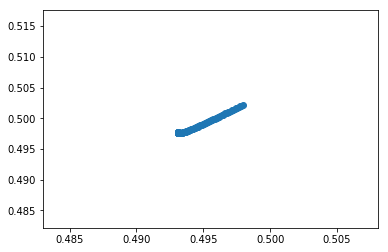

[[ 0.50206059 -0.50215432]
 [ 0.50206255 -0.50215222]
 [ 0.50206451 -0.50215012]
 [ 0.50206646 -0.50214803]
 [-0.497824    0.49796934]
 [-0.49788267  0.49790647]
 [-0.49786311  0.49792743]
 [-0.49784356  0.49794838]]
[array([[0.9102085 , 0.09883842],
       [0.76037099, 0.25849998]]), array([[-0.05764822, -0.06844516],
       [ 0.04118597,  0.0856888 ]])]


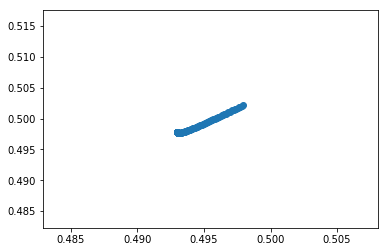

[[ 0.50205977 -0.50215339]
 [ 0.50206177 -0.50215134]
 [ 0.50206377 -0.50214929]
 [ 0.50206577 -0.50214723]
 [-0.49782227  0.49796766]
 [-0.49788224  0.49790612]
 [-0.49786225  0.49792663]
 [-0.49784226  0.49794715]]
[array([[0.91018609, 0.09893072],
       [0.76034858, 0.25859228]]), array([[-0.05900592, -0.06708751],
       [ 0.04255069,  0.0843235 ]])]


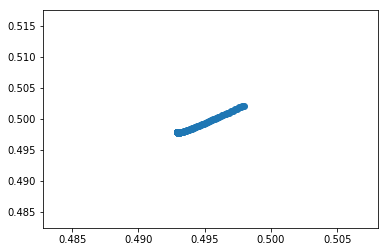

[[ 0.50205894 -0.50215248]
 [ 0.50206098 -0.50215047]
 [ 0.50206302 -0.50214846]
 [ 0.50206506 -0.50214645]
 [-0.49782054  0.49796597]
 [-0.49788182  0.49790575]
 [-0.49786139  0.49792582]
 [-0.49784097  0.4979459 ]]
[array([[0.91016931, 0.09901736],
       [0.76033181, 0.25867892]]), array([[-0.06036336, -0.06573006],
       [ 0.04391518,  0.08295849]])]


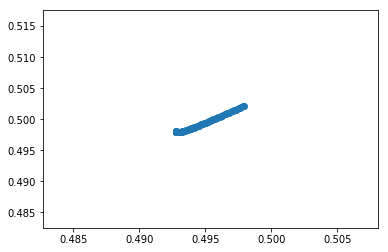

[[ 0.5020581  -0.50215158]
 [ 0.50206018 -0.50214961]
 [ 0.50206227 -0.50214765]
 [ 0.50206436 -0.50214568]
 [-0.49781882  0.49796427]
 [-0.4978814   0.49790537]
 [-0.49786054  0.49792501]
 [-0.49783968  0.49794464]]
[array([[0.91015816, 0.09909834],
       [0.76032066, 0.2587599 ]]), array([[-0.06172056, -0.0643728 ],
       [ 0.04527948,  0.08159372]])]


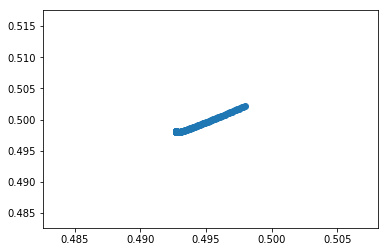

[[ 0.50205725 -0.50215068]
 [ 0.50205938 -0.50214876]
 [ 0.50206151 -0.50214684]
 [ 0.50206364 -0.50214492]
 [-0.4978171   0.49796257]
 [-0.49788098  0.49790499]
 [-0.49785969  0.49792419]
 [-0.4978384   0.49794338]]
[array([[0.91015264, 0.09917367],
       [0.76031513, 0.25883522]]), array([[-0.06307756, -0.0630157 ],
       [ 0.04664359,  0.08022917]])]


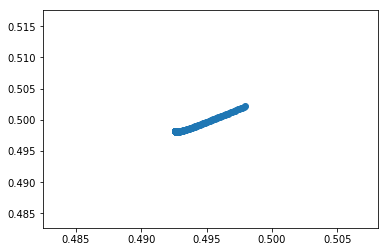

[[ 0.50205641 -0.50214979]
 [ 0.50205858 -0.50214792]
 [ 0.50206075 -0.50214604]
 [ 0.50206293 -0.50214417]
 [-0.49781539  0.49796087]
 [-0.49788057  0.49790461]
 [-0.49785884  0.49792336]
 [-0.49783711  0.49794212]]
[array([[0.91015274, 0.09924333],
       [0.76031523, 0.25890489]]), array([[-0.06443438, -0.06165876],
       [ 0.04800754,  0.07886482]])]


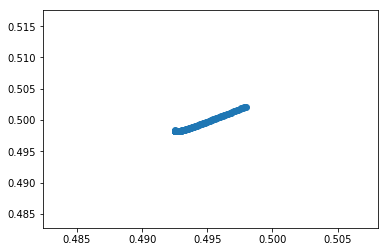

[[ 0.50205556 -0.50214891]
 [ 0.50205778 -0.50214708]
 [ 0.50205999 -0.50214525]
 [ 0.50206221 -0.50214342]
 [-0.49781368  0.49795917]
 [-0.49788016  0.49790422]
 [-0.497858    0.49792254]
 [-0.49783584  0.49794085]]
[array([[0.91015847, 0.09930734],
       [0.76032096, 0.25896889]]), array([[-0.06579104, -0.06030194],
       [ 0.04937135,  0.07750062]])]


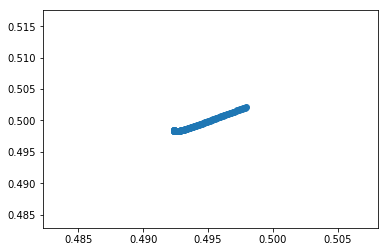

[[ 0.50205471 -0.50214803]
 [ 0.50205697 -0.50214625]
 [ 0.50205923 -0.50214446]
 [ 0.50206149 -0.50214267]
 [-0.49781197  0.49795746]
 [-0.49787975  0.49790383]
 [-0.49785715  0.49792171]
 [-0.49783456  0.49793959]]
[array([[0.91016982, 0.09936569],
       [0.76033232, 0.25902724]]), array([[-0.06714757, -0.05894524],
       [ 0.05073505,  0.07613657]])]


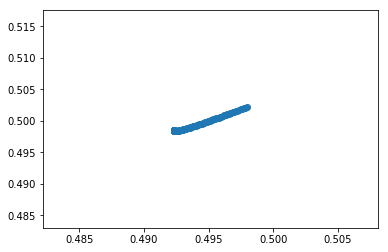

[[ 0.50205386 -0.50214716]
 [ 0.50205616 -0.50214541]
 [ 0.50205846 -0.50214367]
 [ 0.50206077 -0.50214192]
 [-0.49781025  0.49795575]
 [-0.49787934  0.49790343]
 [-0.49785631  0.49792088]
 [-0.49783328  0.49793832]]
[array([[0.9101868 , 0.09941838],
       [0.76034929, 0.25907994]]), array([[-0.068504  , -0.05758862],
       [ 0.05209864,  0.07477263]])]


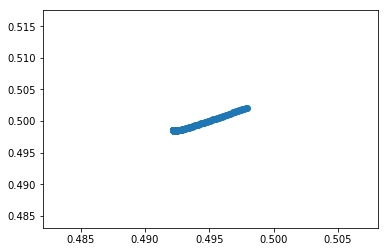

[[ 0.502053   -0.50214629]
 [ 0.50205535 -0.50214459]
 [ 0.5020577  -0.50214288]
 [ 0.50206005 -0.50214118]
 [-0.49780854  0.49795405]
 [-0.49787893  0.49790304]
 [-0.49785547  0.49792004]
 [-0.497832    0.49793705]]
[array([[0.9102094 , 0.09946542],
       [0.76037189, 0.25912698]]), array([[-0.06986034, -0.05623208],
       [ 0.05346217,  0.07340877]])]


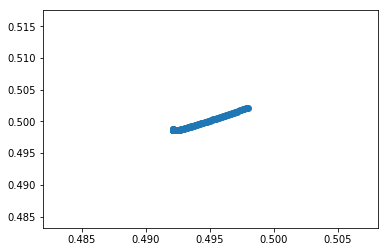

[[ 0.50205215 -0.50214542]
 [ 0.50205454 -0.50214376]
 [ 0.50205693 -0.5021421 ]
 [ 0.50205932 -0.50214044]
 [-0.49780683  0.49795234]
 [-0.49787853  0.49790264]
 [-0.49785462  0.49791921]
 [-0.49783073  0.49793578]]
[array([[0.91023763, 0.0995068 ],
       [0.76040012, 0.25916836]]), array([[-0.07121662, -0.05487558],
       [ 0.05482564,  0.07204498]])]


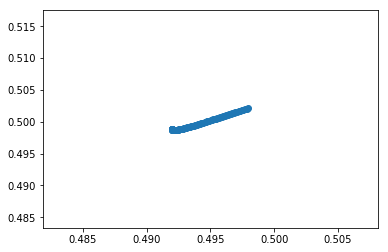

[[ 0.5020513  -0.50214455]
 [ 0.50205373 -0.50214294]
 [ 0.50205616 -0.50214132]
 [ 0.5020586  -0.50213971]
 [-0.49780512  0.49795064]
 [-0.49787812  0.49790224]
 [-0.49785378  0.49791838]
 [-0.49782945  0.49793451]]
[array([[0.91027147, 0.09954253],
       [0.76043396, 0.25920409]]), array([[-0.07257288, -0.0535191 ],
       [ 0.05618909,  0.07068123]])]


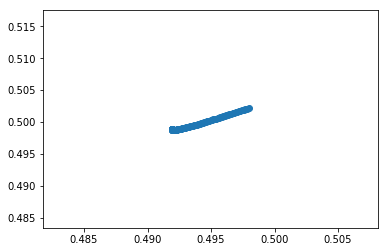

[[ 0.50205044 -0.50214368]
 [ 0.50205292 -0.50214211]
 [ 0.50205539 -0.50214054]
 [ 0.50205787 -0.50213897]
 [-0.4978034   0.49794893]
 [-0.49787771  0.49790185]
 [-0.49785294  0.49791754]
 [-0.49782817  0.49793324]]
[array([[0.91031094, 0.09957261],
       [0.76047343, 0.25923416]]), array([[-0.07392912, -0.05216262],
       [ 0.05755254,  0.06931748]])]


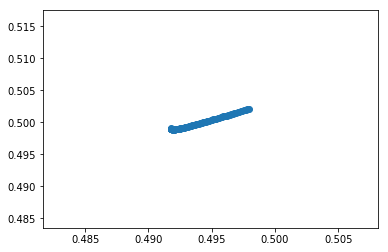

[[ 0.50204958 -0.50214282]
 [ 0.5020521  -0.50214129]
 [ 0.50205462 -0.50213976]
 [ 0.50205715 -0.50213824]
 [-0.49780169  0.49794723]
 [-0.4978773   0.49790145]
 [-0.4978521   0.49791671]
 [-0.49782689  0.49793197]]
[array([[0.91035604, 0.09959702],
       [0.76051853, 0.25925858]]), array([[-0.07528537, -0.05080613],
       [ 0.058916  ,  0.06795373]])]


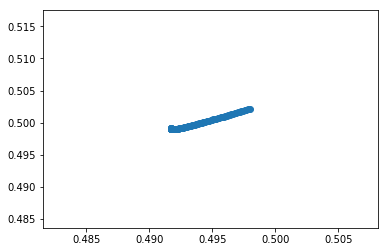

[[ 0.50204872 -0.50214195]
 [ 0.50205129 -0.50214047]
 [ 0.50205385 -0.50213899]
 [ 0.50205642 -0.50213751]
 [-0.49779997  0.49794552]
 [-0.4978769   0.49790105]
 [-0.49785125  0.49791588]
 [-0.49782561  0.4979307 ]]
[array([[0.91040675, 0.09961579],
       [0.76056924, 0.25927735]]), array([[-0.07664166, -0.04944958],
       [ 0.06027951,  0.06658994]])]


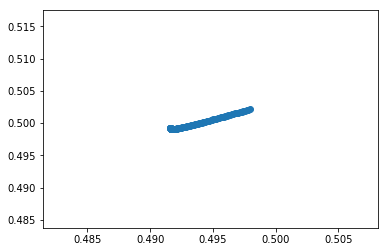

[[ 0.50204787 -0.50214109]
 [ 0.50205047 -0.50213965]
 [ 0.50205308 -0.50213821]
 [ 0.50205569 -0.50213677]
 [-0.49779825  0.49794382]
 [-0.49787649  0.49790065]
 [-0.49785041  0.49791504]
 [-0.49782433  0.49792943]]
[array([[0.91046309, 0.0996289 ],
       [0.76062558, 0.25929046]]), array([[-0.077998  , -0.04809298],
       [ 0.06164308,  0.06522609]])]


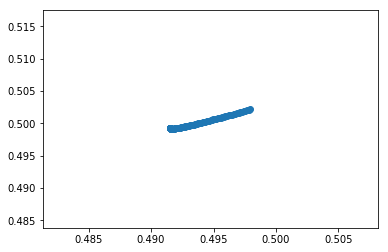

[[ 0.50204701 -0.50214023]
 [ 0.50204966 -0.50213883]
 [ 0.50205231 -0.50213744]
 [ 0.50205496 -0.50213604]
 [-0.49779653  0.49794212]
 [-0.49787608  0.49790025]
 [-0.49784956  0.49791421]
 [-0.49782304  0.49792816]]
[array([[0.91052506, 0.09963635],
       [0.76068755, 0.25929791]]), array([[-0.07935443, -0.04673628],
       [ 0.06300675,  0.06386217]])]


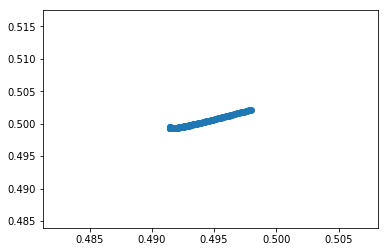

[[ 0.50204614 -0.50213937]
 [ 0.50204884 -0.50213802]
 [ 0.50205154 -0.50213667]
 [ 0.50205423 -0.50213531]
 [-0.49779481  0.49794041]
 [-0.49787567  0.49789985]
 [-0.49784871  0.49791337]
 [-0.49782176  0.49792689]]
[array([[0.91059264, 0.09963815],
       [0.76075513, 0.25929971]]), array([[-0.08071097, -0.04537947],
       [ 0.06437053,  0.06249813]])]


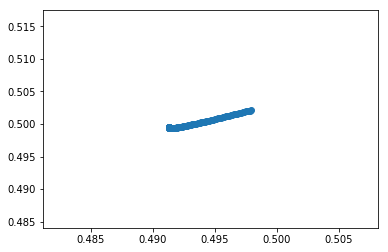

[[ 0.50204528 -0.50213851]
 [ 0.50204802 -0.5021372 ]
 [ 0.50205076 -0.50213589]
 [ 0.5020535  -0.50213458]
 [-0.49779309  0.49793871]
 [-0.49787526  0.49789945]
 [-0.49784787  0.49791254]
 [-0.49782048  0.49792563]]
[array([[0.91066585, 0.0996343 ],
       [0.76082834, 0.25929585]]), array([[-0.08206763, -0.04402252],
       [ 0.06573445,  0.06113396]])]


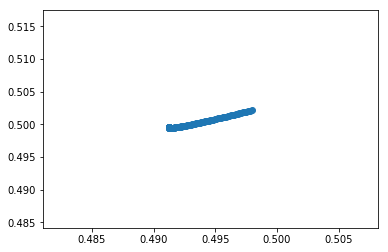

[[ 0.50204442 -0.50213765]
 [ 0.5020472  -0.50213639]
 [ 0.50204999 -0.50213512]
 [ 0.50205277 -0.50213385]
 [-0.49779136  0.49793701]
 [-0.49787485  0.49789905]
 [-0.49784702  0.49791171]
 [-0.49781919  0.49792436]]
[array([[0.91074469, 0.09962478],
       [0.76090718, 0.25928634]]), array([[-0.08342444, -0.04266541],
       [ 0.06709852,  0.05976964]])]


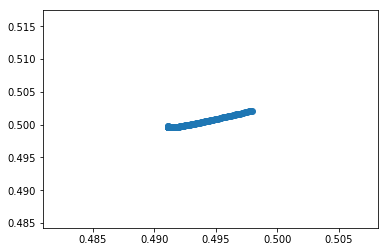

[[ 0.50204356 -0.50213679]
 [ 0.50204638 -0.50213557]
 [ 0.50204921 -0.50213435]
 [ 0.50205204 -0.50213313]
 [-0.49778963  0.49793531]
 [-0.49787444  0.49789865]
 [-0.49784617  0.49791087]
 [-0.4978179   0.49792309]]
[array([[0.91082915, 0.09960961],
       [0.76099164, 0.25927117]]), array([[-0.08478143, -0.04130812],
       [ 0.06846279,  0.05840514]])]


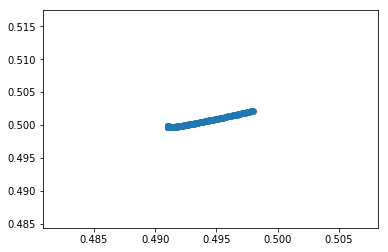

[[ 0.50204269 -0.50213594]
 [ 0.50204556 -0.50213476]
 [ 0.50204843 -0.50213358]
 [ 0.50205131 -0.5021324 ]
 [-0.4977879   0.49793361]
 [-0.49787403  0.49789825]
 [-0.49784532  0.49791004]
 [-0.49781661  0.49792182]]
[array([[0.91091924, 0.09958879],
       [0.76108173, 0.25925034]]), array([[-0.08613862, -0.03995063],
       [ 0.06982726,  0.05704044]])]


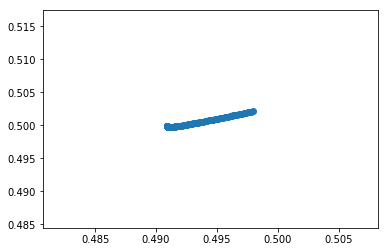

[[ 0.50204182 -0.50213508]
 [ 0.50204474 -0.50213394]
 [ 0.50204766 -0.50213281]
 [ 0.50205057 -0.50213167]
 [-0.49778617  0.4979319 ]
 [-0.49787362  0.49789785]
 [-0.49784447  0.4979092 ]
 [-0.49781532  0.49792055]]
[array([[0.91101495, 0.0995623 ],
       [0.76117744, 0.25922386]]), array([[-0.08749603, -0.03859291],
       [ 0.07119196,  0.05567552]])]


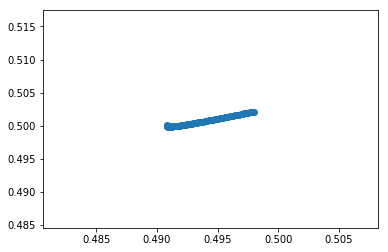

[[ 0.50204096 -0.50213422]
 [ 0.50204392 -0.50213313]
 [ 0.50204688 -0.50213204]
 [ 0.50204984 -0.50213094]
 [-0.49778443  0.4979302 ]
 [-0.49787321  0.49789745]
 [-0.49784361  0.49790837]
 [-0.49781402  0.49791929]]
[array([[0.91111629, 0.09953016],
       [0.76127878, 0.25919171]]), array([[-0.08885368, -0.03723494],
       [ 0.07255692,  0.05431034]])]


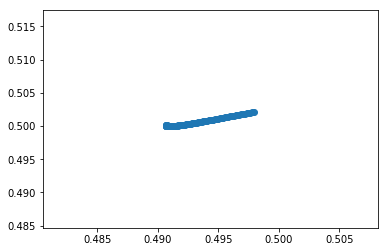

[[ 0.50204009 -0.50213336]
 [ 0.50204309 -0.50213231]
 [ 0.5020461  -0.50213127]
 [ 0.5020491  -0.50213022]
 [-0.4977827   0.4979285 ]
 [-0.4978728   0.49789705]
 [-0.49784276  0.49790753]
 [-0.49781273  0.49791802]]
[array([[0.91122326, 0.09949235],
       [0.76138575, 0.25915391]]), array([[-0.0902116 , -0.03587669],
       [ 0.07392216,  0.0529449 ]])]


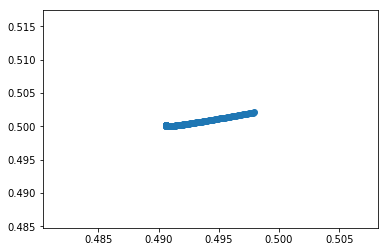

[[ 0.50203922 -0.50213251]
 [ 0.50204227 -0.5021315 ]
 [ 0.50204531 -0.5021305 ]
 [ 0.50204836 -0.50212949]
 [-0.49778096  0.4979268 ]
 [-0.49787238  0.49789665]
 [-0.4978419   0.4979067 ]
 [-0.49781143  0.49791675]]
[array([[0.91133586, 0.09944888],
       [0.76149835, 0.25911044]]), array([[-0.09156981, -0.03451815],
       [ 0.0752877 ,  0.05157915]])]


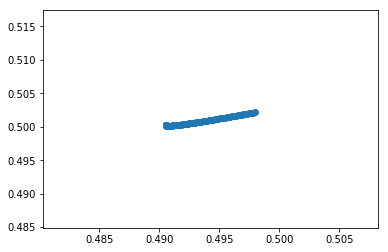

[[ 0.50203835 -0.50213165]
 [ 0.50204144 -0.50213069]
 [ 0.50204453 -0.50212973]
 [ 0.50204762 -0.50212876]
 [-0.49777921  0.49792509]
 [-0.49787197  0.49789625]
 [-0.49784105  0.49790586]
 [-0.49781013  0.49791548]]
[array([[0.91145409, 0.09939975],
       [0.76161658, 0.25906131]]), array([[-0.09292833, -0.03315929],
       [ 0.07665356,  0.05021309]])]


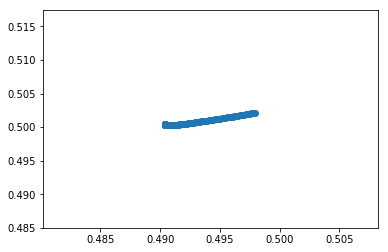

[[ 0.50203747 -0.50213079]
 [ 0.50204061 -0.50212988]
 [ 0.50204375 -0.50212896]
 [ 0.50204688 -0.50212804]
 [-0.49777747  0.49792339]
 [-0.49787155  0.49789584]
 [-0.49784019  0.49790503]
 [-0.49780882  0.49791421]]
[array([[0.91157796, 0.09934496],
       [0.76174045, 0.25900652]]), array([[-0.09428719, -0.03180008],
       [ 0.07801978,  0.04884668]])]


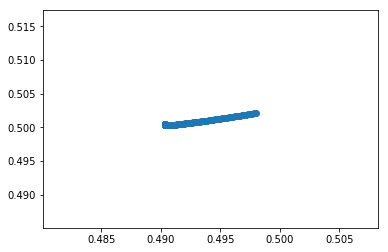

[[ 0.5020366  -0.50212994]
 [ 0.50203978 -0.50212906]
 [ 0.50204296 -0.50212819]
 [ 0.50204614 -0.50212731]
 [-0.49777572  0.49792169]
 [-0.49787114  0.49789544]
 [-0.49783933  0.49790419]
 [-0.49780752  0.49791294]]
[array([[0.91170745, 0.0992845 ],
       [0.76186994, 0.25894606]]), array([[-0.09564641, -0.03044051],
       [ 0.07938638,  0.04747991]])]


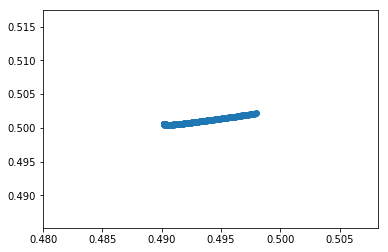

[[ 0.50203572 -0.50212908]
 [ 0.50203895 -0.50212825]
 [ 0.50204217 -0.50212742]
 [ 0.5020454  -0.50212659]
 [-0.49777396  0.49791998]
 [-0.49787072  0.49789504]
 [-0.49783847  0.49790335]
 [-0.49780621  0.49791167]]
[array([[0.91184258, 0.09921837],
       [0.76200508, 0.25887993]]), array([[-0.09700602, -0.02908054],
       [ 0.08075337,  0.04611274]])]


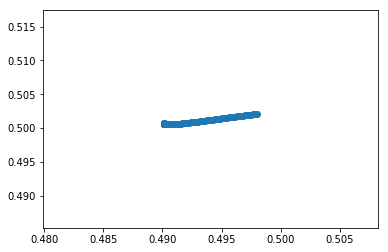

[[ 0.50203484 -0.50212822]
 [ 0.50203811 -0.50212744]
 [ 0.50204138 -0.50212665]
 [ 0.50204465 -0.50212586]
 [-0.49777221  0.49791828]
 [-0.49787031  0.49789464]
 [-0.4978376   0.49790252]
 [-0.4978049   0.4979104 ]]
[array([[0.91198335, 0.09914658],
       [0.76214584, 0.25880813]]), array([[-0.09836602, -0.02772017],
       [ 0.08212078,  0.04474516]])]


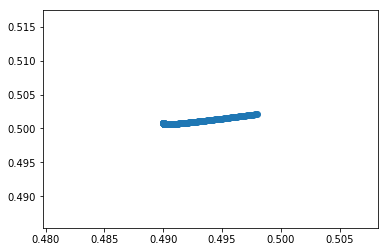

[[ 0.50203396 -0.50212737]
 [ 0.50203728 -0.50212662]
 [ 0.50204059 -0.50212588]
 [ 0.50204391 -0.50212513]
 [-0.49777045  0.49791657]
 [-0.49786989  0.49789423]
 [-0.49783674  0.49790168]
 [-0.49780359  0.49790913]]
[array([[0.91212976, 0.09906911],
       [0.76229225, 0.25873067]]), array([[-0.09972646, -0.02635935],
       [ 0.08348863,  0.04337714]])]


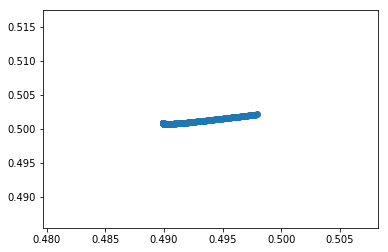

[[ 0.50203308 -0.50212651]
 [ 0.50203644 -0.50212581]
 [ 0.5020398  -0.50212511]
 [ 0.50204316 -0.5021244 ]
 [-0.49776868  0.49791486]
 [-0.49786947  0.49789383]
 [-0.49783587  0.49790084]
 [-0.49780227  0.49790785]]
[array([[0.91228181, 0.09898597],
       [0.7624443 , 0.25864753]]), array([[-0.10108735, -0.02499808],
       [ 0.08485696,  0.04200866]])]


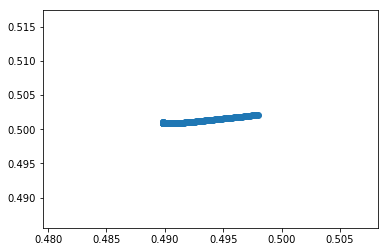

[[ 0.50203219 -0.50212565]
 [ 0.5020356  -0.50212499]
 [ 0.502039   -0.50212434]
 [ 0.50204241 -0.50212368]
 [-0.49776692  0.49791316]
 [-0.49786905  0.49789343]
 [-0.497835    0.4979    ]
 [-0.49780096  0.49790658]]
[array([[0.9124395 , 0.09889716],
       [0.76260199, 0.25855872]]), array([[-0.10244872, -0.02363633],
       [ 0.08622578,  0.04063969]])]


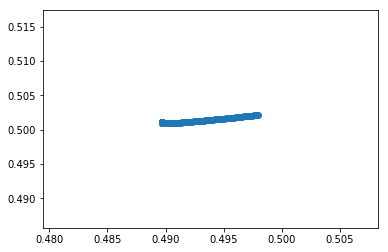

[[ 0.50203131 -0.50212479]
 [ 0.50203476 -0.50212418]
 [ 0.50203821 -0.50212356]
 [ 0.50204166 -0.50212295]
 [-0.49776514  0.49791145]
 [-0.49786863  0.49789302]
 [-0.49783413  0.49789916]
 [-0.49779964  0.49790531]]
[array([[0.91260283, 0.09880268],
       [0.76276532, 0.25846423]]), array([[-0.10381058, -0.02227407],
       [ 0.08759511,  0.03927021]])]


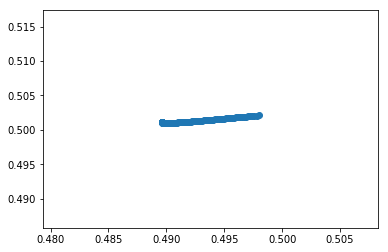

[[ 0.50203042 -0.50212393]
 [ 0.50203391 -0.50212336]
 [ 0.50203741 -0.50212279]
 [ 0.50204091 -0.50212222]
 [-0.49776337  0.49790973]
 [-0.49786821  0.49789262]
 [-0.49783326  0.49789832]
 [-0.49779831  0.49790403]]
[array([[0.91277181, 0.09870251],
       [0.7629343 , 0.25836407]]), array([[-0.10517297, -0.02091128],
       [ 0.08896499,  0.0379002 ]])]


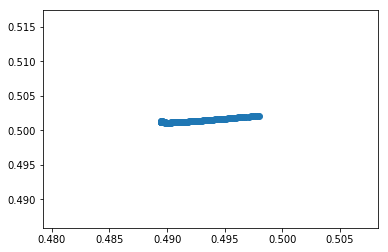

[[ 0.50202953 -0.50212307]
 [ 0.50203307 -0.50212255]
 [ 0.50203661 -0.50212202]
 [ 0.50204015 -0.50212149]
 [-0.49776159  0.49790802]
 [-0.49786779  0.49789221]
 [-0.49783239  0.49789748]
 [-0.49779699  0.49790275]]
[array([[0.91294644, 0.09859666],
       [0.76310893, 0.25825822]]), array([[-0.1065359 , -0.01954794],
       [ 0.09033543,  0.03652963]])]


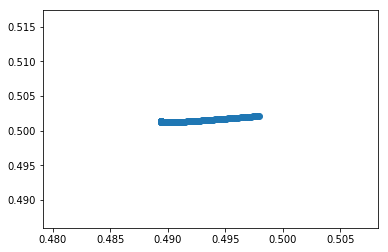

[[ 0.50202863 -0.50212221]
 [ 0.50203222 -0.50212173]
 [ 0.50203581 -0.50212125]
 [ 0.50203939 -0.50212076]
 [-0.49775981  0.49790631]
 [-0.49786737  0.49789181]
 [-0.49783151  0.49789664]
 [-0.49779566  0.49790147]]
[array([[0.91312671, 0.09848513],
       [0.7632892 , 0.25814669]]), array([[-0.1078994 , -0.01818403],
       [ 0.09170645,  0.03515848]])]


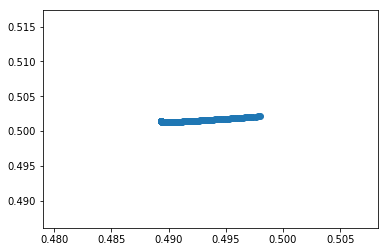

[[ 0.50202774 -0.50212135]
 [ 0.50203137 -0.50212091]
 [ 0.502035   -0.50212047]
 [ 0.50203863 -0.50212003]
 [-0.49775802  0.49790459]
 [-0.49786694  0.4978914 ]
 [-0.49783063  0.4978958 ]
 [-0.49779432  0.49790019]]
[array([[0.91331264, 0.09836792],
       [0.76347514, 0.25802948]]), array([[-0.10926349, -0.01681951],
       [ 0.09307809,  0.03378672]])]


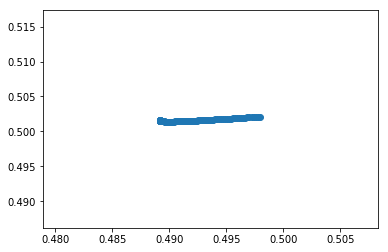

[[ 0.50202684 -0.50212049]
 [ 0.50203052 -0.5021201 ]
 [ 0.5020342  -0.5021197 ]
 [ 0.50203787 -0.5021193 ]
 [-0.49775623  0.49790287]
 [-0.49786652  0.49789099]
 [-0.49782975  0.49789495]
 [-0.49779299  0.49789891]]
[array([[0.91350423, 0.09824502],
       [0.76366672, 0.25790658]]), array([[-0.11062819, -0.01545438],
       [ 0.09445036,  0.03241433]])]


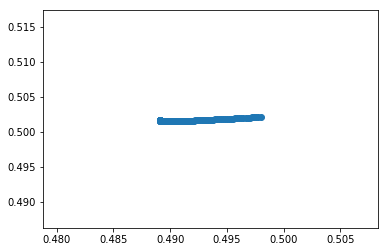

[[ 0.50202594 -0.50211963]
 [ 0.50202966 -0.50211928]
 [ 0.50203339 -0.50211892]
 [ 0.50203711 -0.50211857]
 [-0.49775443  0.49790115]
 [-0.4978661   0.49789059]
 [-0.49782887  0.49789411]
 [-0.49779165  0.49789763]]
[array([[0.91370147, 0.09811643],
       [0.76386396, 0.25777799]]), array([[-0.11199353, -0.0140886 ],
       [ 0.0958233 ,  0.0310413 ]])]


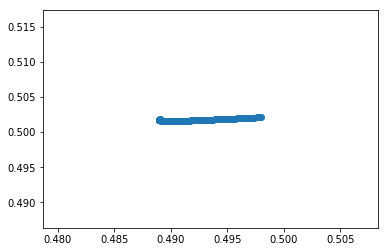

[[ 0.50202504 -0.50211877]
 [ 0.50202881 -0.50211846]
 [ 0.50203258 -0.50211815]
 [ 0.50203634 -0.50211784]
 [-0.49775263  0.49789943]
 [-0.49786567  0.49789018]
 [-0.49782799  0.49789326]
 [-0.49779031  0.49789635]]
[array([[0.91390438, 0.09798214],
       [0.76406687, 0.2576437 ]]), array([[-0.11335953, -0.01272215],
       [ 0.09719691,  0.02966758]])]


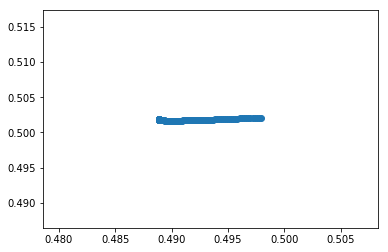

[[ 0.50202413 -0.5021179 ]
 [ 0.50202795 -0.50211764]
 [ 0.50203176 -0.50211737]
 [ 0.50203558 -0.50211711]
 [-0.49775083  0.49789771]
 [-0.49786524  0.49788977]
 [-0.4978271   0.49789242]
 [-0.49778896  0.49789506]]
[array([[0.91411294, 0.09784217],
       [0.76427543, 0.25750372]]), array([[-0.11472622, -0.01135502],
       [ 0.09857123,  0.02829317]])]


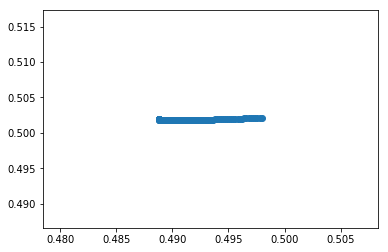

[[ 0.50202322 -0.50211704]
 [ 0.50202708 -0.50211682]
 [ 0.50203095 -0.50211659]
 [ 0.50203481 -0.50211637]
 [-0.49774902  0.49789598]
 [-0.49786481  0.49788936]
 [-0.49782621  0.49789157]
 [-0.49778761  0.49789378]]
[array([[0.91432717, 0.09769649],
       [0.76448967, 0.25735804]]), array([[-0.11609362, -0.00998716],
       [ 0.09994629,  0.02691803]])]


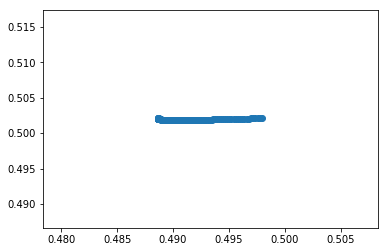

[[ 0.50202231 -0.50211617]
 [ 0.50202622 -0.50211599]
 [ 0.50203013 -0.50211582]
 [ 0.50203403 -0.50211564]
 [-0.4977472   0.49789425]
 [-0.49786439  0.49788895]
 [-0.49782532  0.49789072]
 [-0.49778626  0.49789249]]
[array([[0.91454708, 0.09754511],
       [0.76470957, 0.25720666]]), array([[-0.11746174, -0.00861857],
       [ 0.10132209,  0.02554215]])]


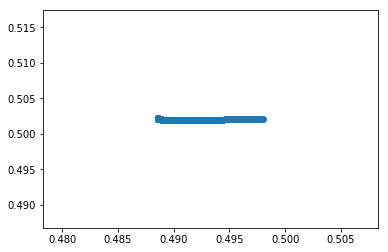

[[ 0.5020214  -0.5021153 ]
 [ 0.50202535 -0.50211517]
 [ 0.50202931 -0.50211504]
 [ 0.50203326 -0.5021149 ]
 [-0.49774538  0.49789252]
 [-0.49786396  0.49788854]
 [-0.49782443  0.49788987]
 [-0.4977849   0.4978912 ]]
[array([[0.91477265, 0.09738802],
       [0.76493514, 0.25704958]]), array([[-0.11883062, -0.00724922],
       [ 0.10269868,  0.02416549]])]


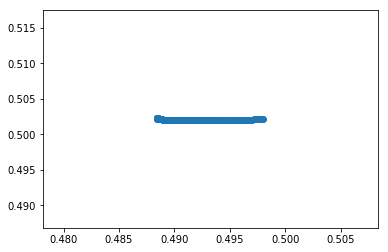

[[ 0.50202048 -0.50211443]
 [ 0.50202448 -0.50211434]
 [ 0.50202848 -0.50211426]
 [ 0.50203248 -0.50211417]
 [-0.49774356  0.49789079]
 [-0.49786352  0.49788813]
 [-0.49782353  0.49788902]
 [-0.49778354  0.4978899 ]]
[array([[0.9150039 , 0.09722523],
       [0.76516639, 0.25688679]]), array([[-0.12020027, -0.00587909],
       [ 0.10407606,  0.02278804]])]


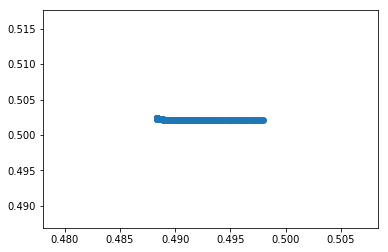

[[ 0.50201956 -0.50211356]
 [ 0.50202361 -0.50211352]
 [ 0.50202766 -0.50211347]
 [ 0.5020317  -0.50211343]
 [-0.49774173  0.49788905]
 [-0.49786309  0.49788772]
 [-0.49782263  0.49788817]
 [-0.49778218  0.49788861]]
[array([[0.91524082, 0.09705673],
       [0.76540331, 0.25671829]]), array([[-0.12157073, -0.00450815],
       [ 0.10545428,  0.02140976]])]


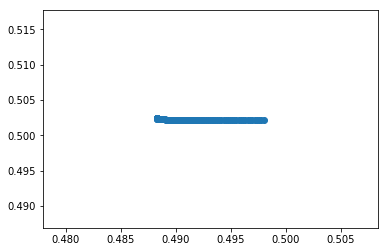

[[ 0.50201864 -0.50211269]
 [ 0.50202273 -0.50211269]
 [ 0.50202683 -0.50211269]
 [ 0.50203092 -0.50211269]
 [-0.49773989  0.49788731]
 [-0.49786266  0.49788731]
 [-0.49782173  0.49788731]
 [-0.49778081  0.49788731]]
[array([[0.91548343, 0.09688251],
       [0.76564592, 0.25654407]]), array([[-0.12294201, -0.00313637],
       [ 0.10683334,  0.02003065]])]


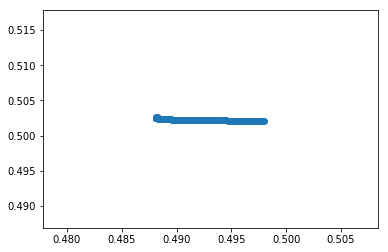

[[ 0.50201771 -0.50211182]
 [ 0.50202185 -0.50211186]
 [ 0.50202599 -0.5021119 ]
 [ 0.50203013 -0.50211195]
 [-0.49773805  0.49788557]
 [-0.49786223  0.4978869 ]
 [-0.49782083  0.49788646]
 [-0.49777944  0.49788601]]
[array([[0.91573172, 0.09670258],
       [0.76589421, 0.25636413]]), array([[-0.12431414, -0.00176374],
       [ 0.10821327,  0.01865066]])]


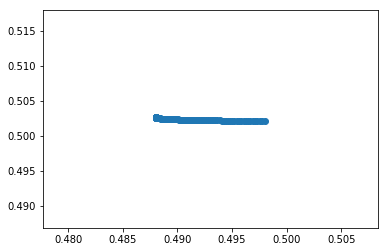

[[ 0.50201678 -0.50211094]
 [ 0.50202097 -0.50211103]
 [ 0.50202516 -0.50211112]
 [ 0.50202935 -0.50211121]
 [-0.49773621  0.49788383]
 [-0.49786179  0.49788649]
 [-0.49781992  0.4978856 ]
 [-0.49777806  0.49788471]]
[array([[0.9159857 , 0.09651692],
       [0.76614819, 0.25617848]]), array([[-0.12568713, -0.00039024],
       [ 0.10959411,  0.01726979]])]


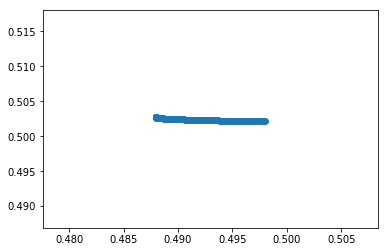

[[ 0.50201585 -0.50211006]
 [ 0.50202009 -0.5021102 ]
 [ 0.50202432 -0.50211033]
 [ 0.50202856 -0.50211046]
 [-0.49773436  0.49788208]
 [-0.49786135  0.49788607]
 [-0.49781902  0.49788474]
 [-0.49777668  0.49788341]]
[array([[0.91624537, 0.09632554],
       [0.76640787, 0.2559871 ]]), array([[-0.12706102,  0.00098417],
       [ 0.11097586,  0.015888  ]])]


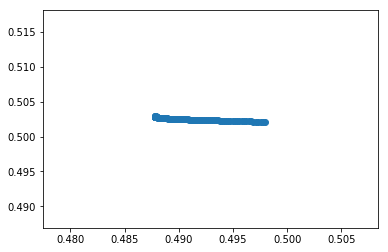

[[ 0.50201492 -0.50210919]
 [ 0.5020192  -0.50210936]
 [ 0.50202348 -0.50210954]
 [ 0.50202776 -0.50210972]
 [-0.4977325   0.49788033]
 [-0.49786092  0.49788566]
 [-0.4978181   0.49788388]
 [-0.4977753   0.4978821 ]]
[array([[0.91651074, 0.09612843],
       [0.76667323, 0.25578999]]), array([[-0.12843583,  0.0023595 ],
       [ 0.11235857,  0.01450527]])]


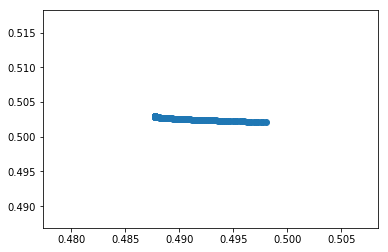

[[ 0.50201398 -0.50210831]
 [ 0.50201831 -0.50210853]
 [ 0.50202264 -0.50210875]
 [ 0.50202696 -0.50210897]
 [-0.49773063  0.49787857]
 [-0.49786048  0.49788524]
 [-0.49781719  0.49788302]
 [-0.49777391  0.49788079]]
[array([[0.91678181, 0.09592559],
       [0.7669443 , 0.25558714]]), array([[-0.12981158,  0.00373577],
       [ 0.11374224,  0.01312158]])]


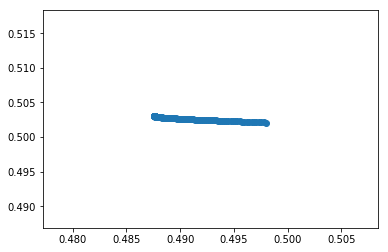

[[ 0.50201303 -0.50210742]
 [ 0.50201741 -0.50210769]
 [ 0.50202179 -0.50210796]
 [ 0.50202617 -0.50210823]
 [-0.49772876  0.49787681]
 [-0.49786004  0.49788483]
 [-0.49781627  0.49788216]
 [-0.49777252  0.49787948]]
[array([[0.91705858, 0.09571701],
       [0.76722107, 0.25537856]]), array([[-0.13118829,  0.00511302],
       [ 0.1151269 ,  0.0117369 ]])]


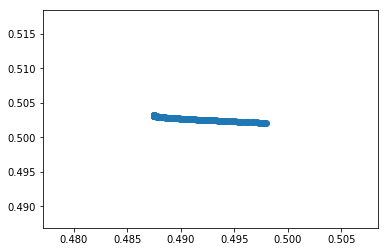

[[ 0.50201209 -0.50210654]
 [ 0.50201651 -0.50210685]
 [ 0.50202094 -0.50210716]
 [ 0.50202536 -0.50210748]
 [-0.49772689  0.49787505]
 [-0.4978596   0.49788441]
 [-0.49781536  0.49788129]
 [-0.49777112  0.49787817]]
[array([[0.91734106, 0.09550268],
       [0.76750355, 0.25516424]]), array([[-0.13256599,  0.00649126],
       [ 0.11651258,  0.01035121]])]


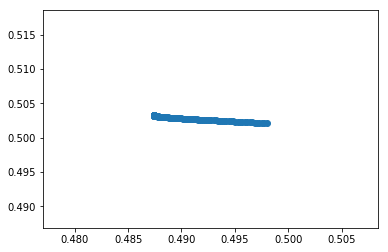

In [5]:
"""
    Train Neural Network
"""
# Create Neural Network
nn = NeuralNetwork(data)
out,lbl = nn.train()

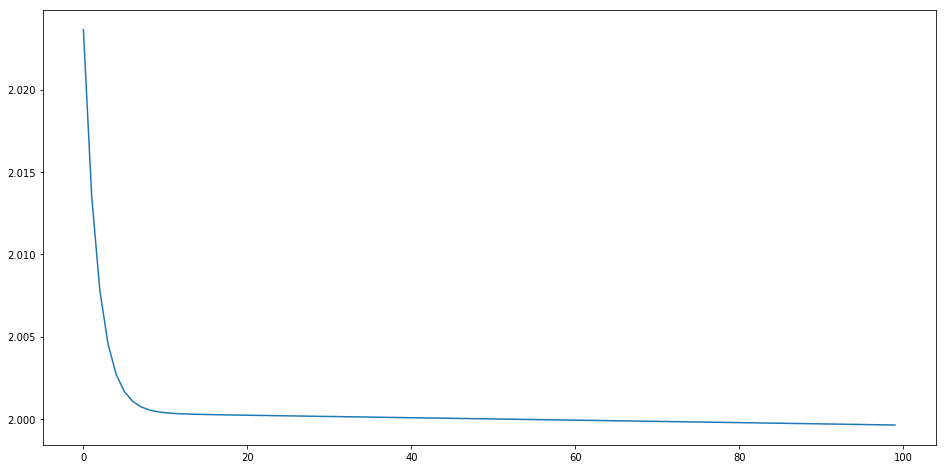

In [6]:
plt.figure(figsize=(16,8))
plt.plot(nn.MSE)
plt.show()

In [7]:
print(out)
print(lbl)
print(nn.weights)

[[0.49798791 0.50210654]
 [0.49798349 0.50210685]
 [0.49797906 0.50210716]
 [0.49797464 0.50210748]
 [0.49772689 0.50212495]
 [0.4978596  0.50211559]
 [0.49781536 0.50211871]
 [0.49777112 0.50212183]]
[1 1 1 1 1 1 1 1]
[array([[0.91734106, 0.09550268],
       [0.76750355, 0.25516424]]), array([[-0.13256599,  0.00649126],
       [ 0.11651258,  0.01035121]])]
